In [36]:
import os, sys, glob
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ROOT_PATH = '../'
res = {}

In [31]:
df = pd.read_csv(f'{ROOT_PATH}data/creditcard.csv')

In [32]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [33]:
y = df.Class.values
df_X = df.drop(['Class', 'Time'], axis=1)
X = df_X.values

In [34]:
from sklearn.preprocessing import Normalizer

transformer = Normalizer().fit(X)
transformer.transform(X)

X_norm = transformer.transform(X)

(-3, 3)

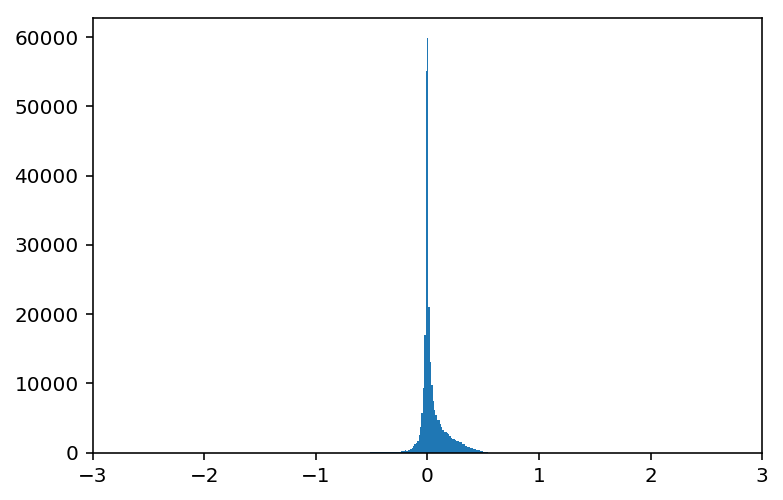

In [35]:
plt.hist(X_norm[:,1], bins=100);
plt.xlim(-3, 3)

In [7]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
        X_norm, y, test_size=0.2, random_state=42)

In [8]:
print(f'{y_test.sum()}, {y_train.sum()}')

98, 394


### PCA

In [10]:
from sklearn.decomposition import PCA

n_components = 6
pca = PCA(n_components=n_components)
pca_transform = pca.fit(X_train)

In [11]:
X_pca = pca_transform.transform(X_train)

In [12]:
X_pca.shape 

(227845, 6)

In [13]:
X_pos = X_pca[y_train==0]
X_anomaly = X_pca[y_train==1]

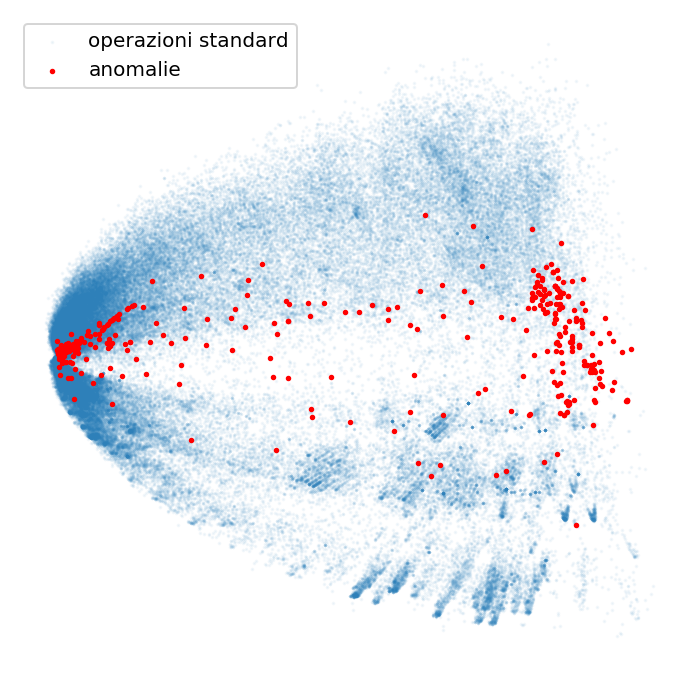

In [42]:
fig, ax = plt.subplots(1, figsize=(6,6))
ax.scatter(X_pos[:, 0], X_pos[:, 1], alpha=0.05, marker='.', s=3, label='operazioni standard')
ax.scatter(X_anomaly[:, 0], X_anomaly[:, 1], alpha=1, color='red', s=3, label='anomalie')
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
plt.axis('off')
fig.savefig('../plots/anomalie.png', bbox_inches='tight', dpi=300)

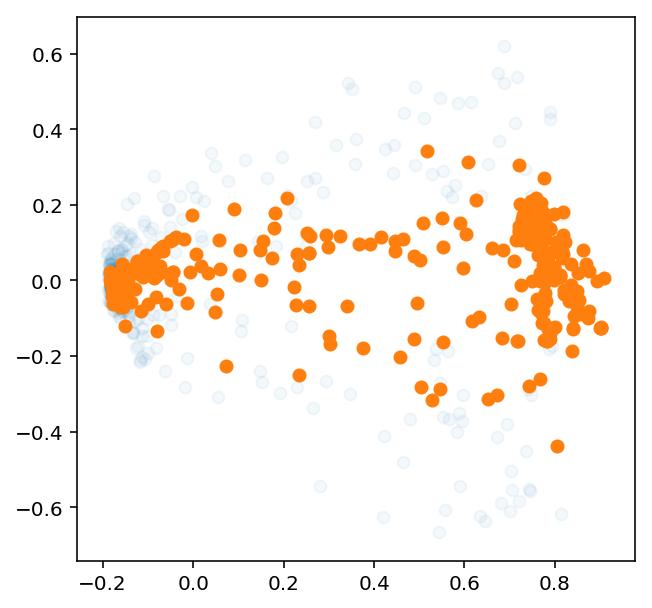

In [252]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.scatter(X_pos[:X_anomaly.shape[0], 0], X_pos[:X_anomaly.shape[0], 1], alpha=0.05)
ax.scatter(X_anomaly[:, 0], X_anomaly[:, 1], alpha=1)

In [253]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [254]:
X_balanced = np.concatenate([X_pos[:X_anomaly.shape[0], :], X_anomaly], axis=0)
y_balanced = np.ones(X_balanced.shape[0])
y_balanced[:X_anomaly.shape[0]] = 0

In [255]:
gbm_param_grid = {
    'n_estimators': range(6, 26),
    'max_depth': range(4, 14),
    'learning_rate': np.linspace(0.1, 1.2, 30),
    'colsample_bytree': np.linspace(0.4, 1, 20)
}

gbm = XGBClassifier(n_estimators=10)

xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "accuracy", 
                                    verbose = 1, n_iter = 100, cv = 4)

xgb_random.fit(X_balanced, y_balanced)
# gbm.fit(X_pca, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    4.0s finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'n_estimators': range(6, 26), 'max_depth': range(4, 14), 'learning_rate': array([0.1    , 0.13793, 0.17586, 0.21379, 0.25172, 0.28966, 0.32759,
       0.36552, 0.40345, 0.44138, 0.47931, 0.51724, 0.55517, 0.5931 ,
       0.63103, 0.66897, 0.7069 , 0.74483, 0.78276, 0.82069, 0.85..., 0.71579, 0.74737, 0.77895, 0.81053,
       0.84211, 0.87368, 0.90526, 0.93684, 0.96842, 1.     ])},
          pre_d

In [256]:
from sklearn.metrics import confusion_matrix

In [257]:
cm = confusion_matrix(y_test, xgb_random.predict(pca_transform.transform(X_test)))

In [258]:

rec = cm[1,1]/(cm[1,0]+cm[1,1])
acc = (cm[1,1]+cm[0,0])/(np.sum(cm))
prec = cm[1,1]/(cm[0,1]+cm[1,1])

print("Accuracy: ", acc)
print("Recall: ", rec)
print("Precision: ", prec)

res[n_components] = [acc, rec, prec]

Accuracy:  0.8913310628138057
Recall:  0.8469387755102041
Precision:  0.013263023330137425


In [259]:
## 2
Recall:  0.8163265306122449
Accuracy:  0.8463888206172536
Precision:  0.009078529278256923

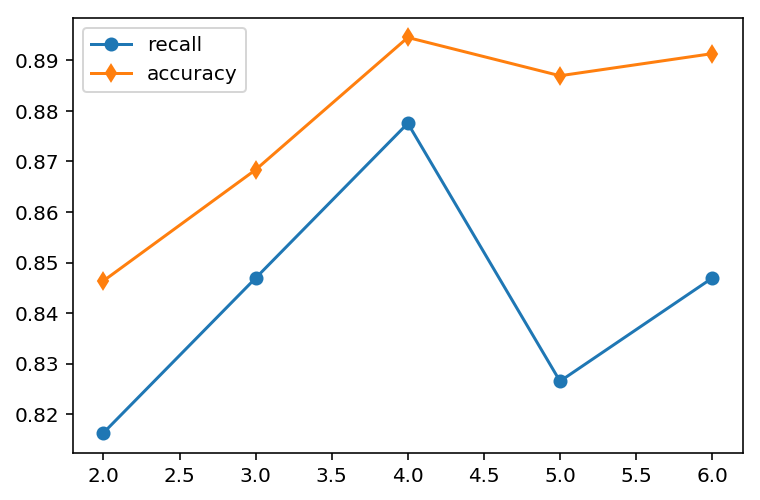

In [260]:
recs = []
accs = []
n_comps = [] 
for n_comp in res:
    recs.append(res[n_comp][1])
    accs.append(res[n_comp][0])

    n_comps.append(n_comp)
    
plt.plot(n_comps, recs, 'o-', label='recall')
plt.plot(n_comps, accs, 'd-', label='accuracy')
plt.legend()

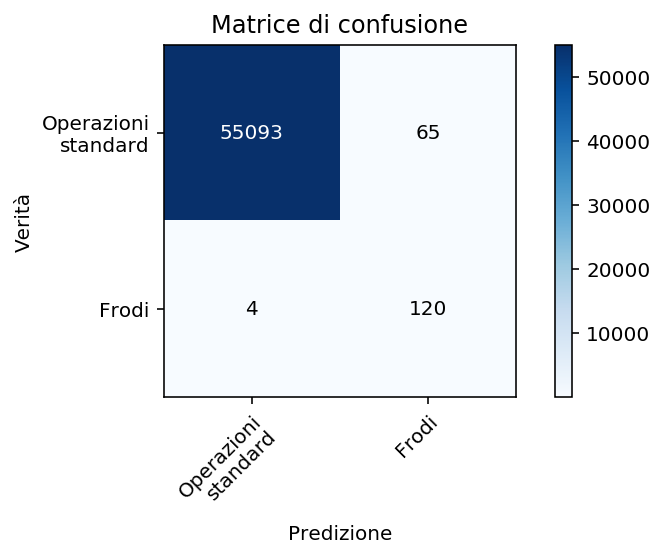

In [54]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

cm = np.array([[55093,  65],
       [   4,    120]], dtype=np.int64)

cmap=plt.cm.Blues
classes=['Operazioni\nstandard', 'Frodi']
title = 'Matrice di confusione'
normalize=False 
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='Verità',
       xlabel='Predizione')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

In [55]:
np.sum(cm)

55282